In [5]:
# %%
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

start_year = 2019
end_year = 2024

wrds_data = []
for year in range(start_year, end_year + 1):
    df_year = pd.read_csv(f'Data/sp500_cleaned_{year}.csv')
    wrds_data.append(df_year)

wrds_file = pd.concat(wrds_data, ignore_index=True)
wrds_file["date"] = pd.to_datetime(wrds_file["date"])

# drop columns with nan values
wrds_file = wrds_file.dropna(axis=1)
wrds_file.describe()
spy = pd.read_csv('Data/SPY.csv') # Date, SPY
spy["Date"] = pd.to_datetime(spy["Date"])
spy["market_ret"] = spy["SPY"].pct_change()
spy.rename(columns={"Date": "date"}, inplace=True) # rename Date to date for merging
spy = spy[['date', 'market_ret']].dropna()

wrds_file = wrds_file.merge(spy, on='date', how='left')
df = wrds_file.copy()


Total factors: 62
Data shape: (30099, 66)
Date range: 2019-01-31 00:00:00 to 2024-12-31 00:00:00

Train: (19996, 66)
Val: (5575, 66)
Test: (5384, 66)

STEP 1: Prepare Data for PCA
Training observations for PCA: 19996
Number of factors: 62

STEP 2: Principal Component Analysis

Variance threshold: 80.0%
Number of components selected: 21
Cumulative variance explained: 80.07%

Top 15 Principal Components:
  PC1:  12.56% (Cumulative:  12.56%) ✓
  PC2:  10.52% (Cumulative:  23.08%) ✓
  PC3:   9.15% (Cumulative:  32.23%) ✓
  PC4:   6.32% (Cumulative:  38.55%) ✓
  PC5:   4.24% (Cumulative:  42.79%) ✓
  PC6:   3.85% (Cumulative:  46.64%) ✓
  PC7:   3.38% (Cumulative:  50.02%) ✓
  PC8:   3.16% (Cumulative:  53.18%) ✓
  PC9:   2.97% (Cumulative:  56.16%) ✓
  PC10:   2.87% (Cumulative:  59.03%) ✓
  PC11:   2.63% (Cumulative:  61.65%) ✓
  PC12:   2.46% (Cumulative:  64.12%) ✓
  PC13:   2.26% (Cumulative:  66.37%) ✓
  PC14:   2.10% (Cumulative:  68.47%) ✓
  PC15:   1.93% (Cumulative:  70.40%) ✓


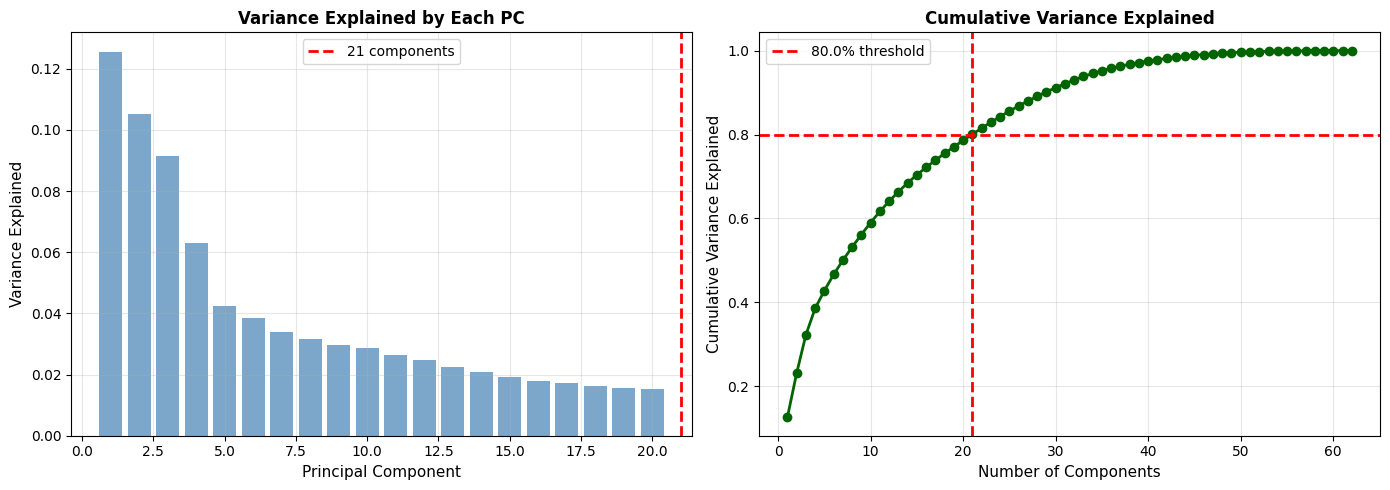


STEP 3: Compute Principal Component Scores
Training data with PC scores: (19996, 87)
PC columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21']

STEP 4: Fama-MacBeth Regression on Principal Components
Number of time periods: 48

Statistically significant PCs (|t| > 1.96): 16 out of 21

All Principal Components - Statistical Summary:
----------------------------------------------------------------------
  PC1     : β̄ = 0.001781, t =   9.280  LONG ↑  ✓ SIGNIFICANT
  PC2     : β̄ = -0.003921, t =  -9.427  SHORT ↓  ✓ SIGNIFICANT
  PC3     : β̄ = 0.023601, t =  14.521  LONG ↑  ✓ SIGNIFICANT
  PC4     : β̄ = -0.003227, t =  -6.243  SHORT ↓  ✓ SIGNIFICANT
  PC5     : β̄ = 0.002110, t =   2.184  LONG ↑  ✓ SIGNIFICANT
  PC6     : β̄ = 0.005238, t =  10.902  LONG ↑  ✓ SIGNIFICANT
  PC7     : β̄ = -0.000975, t =  -3.406  SHORT ↓  ✓ SIGNIFICANT
  PC8     : β̄ = 0.000142, t =   0.119  

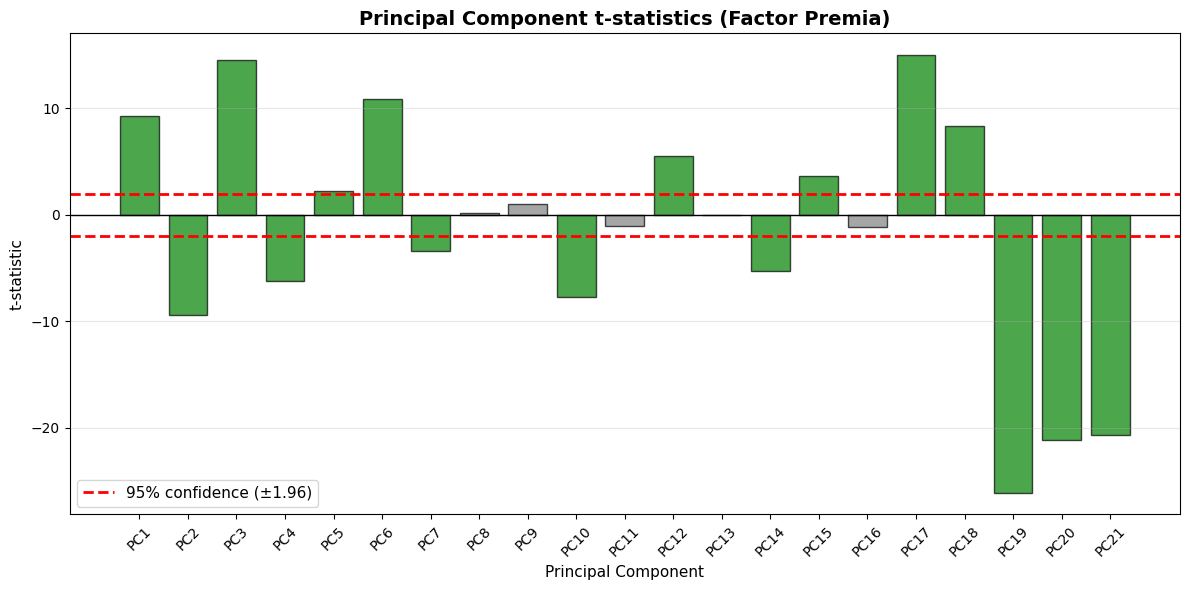


STEP 5: Compute Final PC Factor Premia
Final PCs used: 16
PCs: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC10', 'PC12', 'PC14', 'PC15', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21']

Final PC Factor Premia (β̄):
------------------------------------------------------------
  PC21    : -0.030764  SHORT ↓
  PC3     : 0.024339  LONG ↑
  PC19    : -0.012520  SHORT ↓
  PC17    : 0.010312  LONG ↑
  PC20    : -0.010285  SHORT ↓
  PC18    : 0.006295  LONG ↑
  PC14    : -0.006291  SHORT ↓
  PC6     : 0.005698  LONG ↑
  PC2     : -0.003980  SHORT ↓
  PC4     : -0.003694  SHORT ↓
  PC10    : -0.003115  SHORT ↓
  PC15    : 0.002638  LONG ↑
  PC12    : 0.002273  LONG ↑
  PC5     : 0.002091  LONG ↑
  PC1     : 0.001824  LONG ↑
  PC7     : -0.000962  SHORT ↓

Interpretation - Top 3 Original Factors in Each Significant PC:
----------------------------------------------------------------------

  PC1 (β̄ = 0.001824):
    + 0.3406 × debt_invcap
    + 0.3403 × capital_ratio
    -0.3387 × equity_invcap

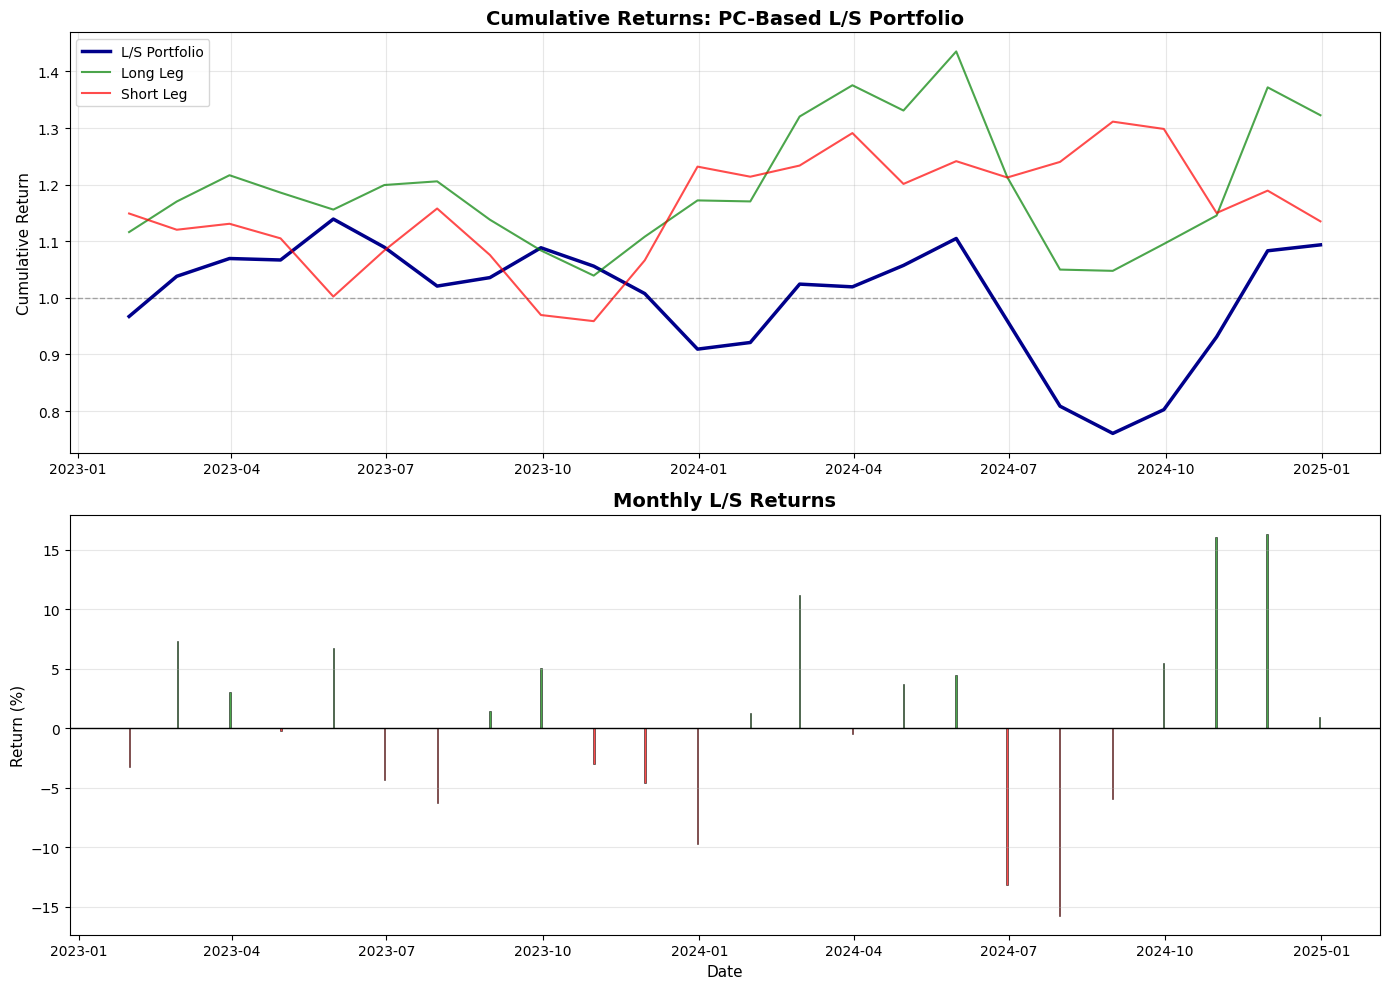

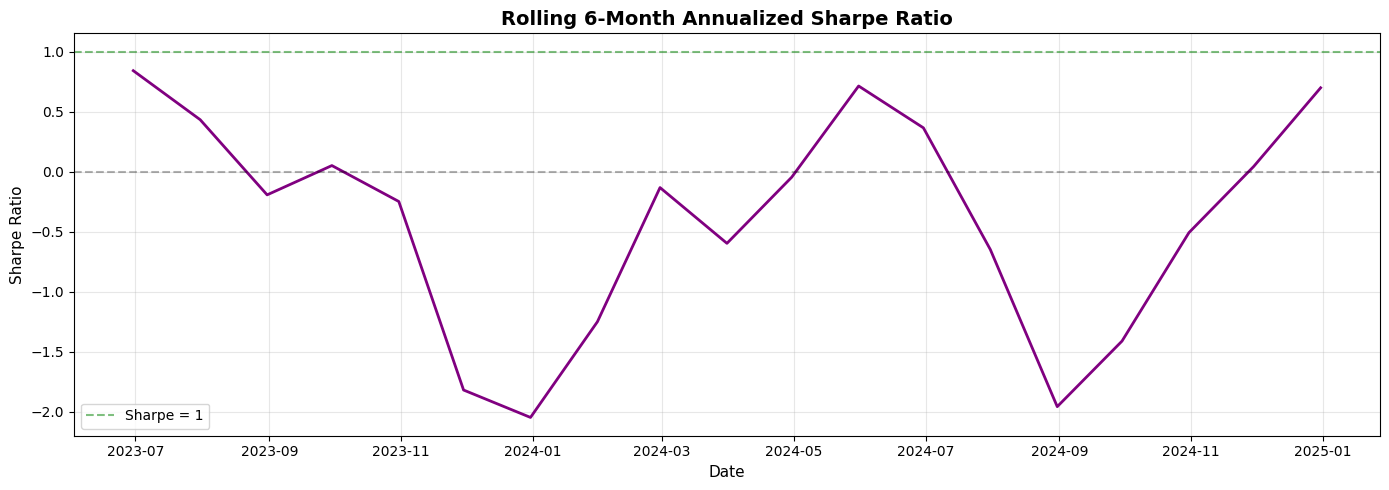


✅ PC-Based Portfolio Analysis Complete!


In [6]:
# ========================================
# PCA-BASED LONG/SHORT PORTFOLIO STRATEGY
# USING PRINCIPAL COMPONENTS AS FACTORS
# ========================================

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import matplotlib.pyplot as plt

# ========================================
# DATA PREPARATION
# ========================================

df = wrds_file.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'ticker'])

# Drop price column if exists
if 'price' in df.columns:
    df = df.drop(columns=['price'])

# Identify factor columns
factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

print(f"Total factors: {len(factor_cols)}")
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Split data
train = df[(df['date'] >= "2019-01-01") & (df['date'] <= "2022-12-31")].copy()
val   = df[(df['date'] >= "2022-12-31") & (df['date'] <= "2023-12-31")].copy()
test  = df[(df['date'] >= "2023-12-31") & (df['date'] <= "2024-12-31")].copy()

print(f"\nTrain: {train.shape}")
print(f"Val: {val.shape}")
print(f"Test: {test.shape}")

# ========================================
# STEP 1: PREPARE DATA FOR PCA
# ========================================

print("\n" + "="*60)
print("STEP 1: Prepare Data for PCA")
print("="*60)

# Create standardized factor matrix from training data
train_factors_list = []

for dt, grp in train.groupby('date'):
    grp_clean = grp.dropna(subset=factor_cols)
    
    if len(grp_clean) < 10:
        continue
    
    # Cross-sectional standardization
    X_raw = grp_clean[factor_cols].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    # Check for NaN/inf
    if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
        continue
    
    train_factors_list.append(X_normalized)

# Stack all time periods
X_train_pca = pd.concat(train_factors_list, ignore_index=True)

print(f"Training observations for PCA: {X_train_pca.shape[0]}")
print(f"Number of factors: {X_train_pca.shape[1]}")

# ========================================
# STEP 2: PERFORM PCA AND FIT MODEL
# ========================================

print("\n" + "="*60)
print("STEP 2: Principal Component Analysis")
print("="*60)

# Fit PCA
pca = PCA()
pca.fit(X_train_pca)

# Variance explained
var_explained = pca.explained_variance_ratio_
cum_var_explained = np.cumsum(var_explained)

# Select number of components (80% variance threshold)
variance_threshold = 0.80
n_components = np.argmax(cum_var_explained >= variance_threshold) + 1

print(f"\nVariance threshold: {variance_threshold*100}%")
print(f"Number of components selected: {n_components}")
print(f"Cumulative variance explained: {cum_var_explained[n_components-1]*100:.2f}%")

# Show top components
print(f"\nTop 15 Principal Components:")
for i in range(min(15, len(var_explained))):
    mark = "✓" if i < n_components else ""
    print(f"  PC{i+1}: {var_explained[i]*100:6.2f}% (Cumulative: {cum_var_explained[i]*100:6.2f}%) {mark}")

# Store the PCA transformation for later use
pca_fitted = PCA(n_components=n_components)
pca_fitted.fit(X_train_pca)

# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, min(21, len(var_explained)+1)), var_explained[:20], alpha=0.7, color='steelblue')
axes[0].axvline(n_components, color='red', linestyle='--', linewidth=2, label=f'{n_components} components')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Variance Explained', fontsize=11)
axes[0].set_title('Variance Explained by Each PC', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cum_var_explained)+1), cum_var_explained, marker='o', linewidth=2, color='darkgreen')
axes[1].axhline(variance_threshold, color='red', linestyle='--', linewidth=2, label=f'{variance_threshold*100}% threshold')
axes[1].axvline(n_components, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=11)
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# STEP 3: COMPUTE PC SCORES FOR TRAINING DATA
# ========================================

print("\n" + "="*60)
print("STEP 3: Compute Principal Component Scores")
print("="*60)

# Add PC scores to training data
train_with_pcs = []

for dt, grp in train.groupby('date'):
    grp_clean = grp.dropna(subset=factor_cols).copy()
    
    if len(grp_clean) < 10:
        continue
    
    # Cross-sectional standardization
    X_raw = grp_clean[factor_cols]
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
        continue
    
    # Transform to PC scores using fitted PCA
    pc_scores = pca_fitted.transform(X_normalized)
    
    # Add PC scores as columns
    for i in range(n_components):
        grp_clean[f'PC{i+1}'] = pc_scores[:, i]
    
    train_with_pcs.append(grp_clean)

train_pcs = pd.concat(train_with_pcs, ignore_index=True)
pc_cols = [f'PC{i+1}' for i in range(n_components)]

print(f"Training data with PC scores: {train_pcs.shape}")
print(f"PC columns: {pc_cols}")

# ========================================
# STEP 4: FAMA-MACBETH REGRESSION WITH PCs
# ========================================

print("\n" + "="*60)
print("STEP 4: Fama-MacBeth Regression on Principal Components")
print("="*60)

beta_time_series = defaultdict(list)
dates_used = []

for dt, grp in train_pcs.groupby('date'):
    grp_clean = grp.dropna(subset=['ret_1m'] + pc_cols)
    
    if grp_clean.shape[0] < n_components + 10:
        continue
    
    X = grp_clean[pc_cols].values
    y = grp_clean['ret_1m'].values
    
    # Cross-sectional regression: r_i,t = alpha_t + sum(beta_j,t * PC_j,i,t) + eps_i,t
    reg = LinearRegression().fit(X, y)
    
    for i, pc_name in enumerate(pc_cols):
        beta_time_series[pc_name].append(reg.coef_[i])
    
    dates_used.append(dt)

T = len(dates_used)
print(f"Number of time periods: {T}")

# Compute t-statistics for each PC
beta_bar = {}
beta_std = {}
t_stats = {}

for pc in pc_cols:
    arr = np.array(beta_time_series[pc])
    beta_bar[pc] = arr.mean()
    beta_std[pc] = arr.std(ddof=1)
    t_stats[pc] = beta_bar[pc] / (beta_std[pc] / np.sqrt(T))

# Select statistically significant PCs
significant_pcs = [pc for pc in pc_cols if abs(t_stats[pc]) > 1.96]

print(f"\nStatistically significant PCs (|t| > 1.96): {len(significant_pcs)} out of {len(pc_cols)}")

print("\nAll Principal Components - Statistical Summary:")
print("-" * 70)
for pc in pc_cols:
    sig_mark = "✓ SIGNIFICANT" if pc in significant_pcs else ""
    direction = "LONG ↑" if beta_bar[pc] > 0 else "SHORT ↓"
    print(f"  {pc:8s}: β̄ = {beta_bar[pc]:8.6f}, t = {t_stats[pc]:7.3f}  {direction}  {sig_mark}")

# Plot t-statistics
plt.figure(figsize=(12, 6))
pcs_list = list(pc_cols)
t_values = [t_stats[pc] for pc in pcs_list]
colors = ['green' if abs(t) > 1.96 else 'gray' for t in t_values]

plt.bar(pcs_list, t_values, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(0, color='black', linewidth=1)
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
plt.title("Principal Component t-statistics (Factor Premia)", fontsize=14, fontweight='bold')
plt.ylabel("t-statistic", fontsize=11)
plt.xlabel("Principal Component", fontsize=11)
plt.xticks(rotation=45)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ========================================
# STEP 5: COMPUTE FINAL PC PREMIA
# ========================================

print("\n" + "="*60)
print("STEP 5: Compute Final PC Factor Premia")
print("="*60)

# Use all PCs or only significant ones
final_pcs = significant_pcs if len(significant_pcs) >= 2 else pc_cols[:min(5, len(pc_cols))]
print(f"Final PCs used: {len(final_pcs)}")
print(f"PCs: {final_pcs}")

# Re-estimate with final PCs
beta_final = defaultdict(list)

for dt, grp in train_pcs.groupby('date'):
    grp_clean = grp.dropna(subset=['ret_1m'] + final_pcs)
    
    if grp_clean.shape[0] < len(final_pcs) + 3:
        continue
    
    X = grp_clean[final_pcs].values
    y = grp_clean['ret_1m'].values
    
    reg = LinearRegression().fit(X, y)
    
    for i, pc in enumerate(final_pcs):
        beta_final[pc].append(reg.coef_[i])

# Average PC premia
beta_bar_final = {pc: np.mean(beta_final[pc]) for pc in final_pcs}

print("\nFinal PC Factor Premia (β̄):")
print("-" * 60)
for pc in sorted(beta_bar_final.keys(), key=lambda x: abs(beta_bar_final[x]), reverse=True):
    direction = "LONG ↑" if beta_bar_final[pc] > 0 else "SHORT ↓"
    print(f"  {pc:8s}: {beta_bar_final[pc]:8.6f}  {direction}")

# Show top factor loadings for interpretation
print("\nInterpretation - Top 3 Original Factors in Each Significant PC:")
print("-" * 70)
loadings = pca_fitted.components_
for pc in final_pcs:
    pc_idx = int(pc.replace('PC', '')) - 1
    pc_loadings = loadings[pc_idx, :]
    
    # Get top 3 absolute loadings
    top_idx = np.argsort(np.abs(pc_loadings))[-5:][::-1]
    
    print(f"\n  {pc} (β̄ = {beta_bar_final[pc]:.6f}):")
    for idx in top_idx:
        loading_val = pc_loadings[idx]
        sign = "+" if loading_val > 0 else ""
        print(f"    {sign}{loading_val:7.4f} × {factor_cols[idx]}")

# ========================================
# STEP 6: PORTFOLIO CONSTRUCTION
# ========================================

print("\n" + "="*60)
print("STEP 6: Portfolio Construction (Val + Test)")
print("="*60)

oos_data = pd.concat([val, test], ignore_index=True).copy()
oos_data = oos_data.sort_values(['ticker', 'date'])

print(f"Out-of-sample data shape: {oos_data.shape}")
print(f"Date range: {oos_data['date'].min()} to {oos_data['date'].max()}")

all_dates = sorted(oos_data['date'].unique())
print(f"Total months: {len(all_dates)}")

portfolio_returns = []

for i in range(len(all_dates) - 1):
    current_date = all_dates[i]
    next_date = all_dates[i + 1]
    
    grp_t = oos_data[oos_data['date'] == current_date].copy()
    grp_t1 = oos_data[oos_data['date'] == next_date].copy()
    
    if len(grp_t) < 20:
        continue
    
    # Normalize factors cross-sectionally at time t
    X_raw = grp_t[factor_cols].copy()
    
    # Check for sufficient data
    if X_raw.dropna().shape[0] < 20:
        continue
    
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
        continue
    
    # Transform to PC scores using TRAINING PCA
    try:
        pc_scores = pca_fitted.transform(X_normalized.fillna(0))
    except:
        continue
    
    # Add PC scores to dataframe
    for j, pc in enumerate(final_pcs):
        pc_idx = int(pc.replace('PC', '')) - 1
        if pc_idx < pc_scores.shape[1]:
            grp_t[pc] = pc_scores[:, pc_idx]
    
    # Predict returns using PC scores
    grp_t['r_pred'] = 0.0
    for pc in final_pcs:
        if pc in grp_t.columns:
            grp_t['r_pred'] += grp_t[pc].fillna(0) * beta_bar_final[pc]
    
    # Add rolling market return expectation
    historical_market = oos_data[oos_data['date'] < current_date]['market_ret']
    if len(historical_market) >= 12:
        E_r_m = historical_market.tail(12).mean()
    else:
        E_r_m = 0.0
    
    grp_t['r_pred'] += E_r_m
    
    grp_t = grp_t.dropna(subset=['r_pred'])
    
    if len(grp_t) < 20:
        continue
    
    # Form portfolio
    grp_t = grp_t.sort_values('r_pred', ascending=False)
    
    long_tickers = grp_t.head(10)['ticker'].tolist()
    short_tickers = grp_t.tail(10)['ticker'].tolist()
    
    # Measure realized returns at t+1
    long_rets = grp_t1[grp_t1['ticker'].isin(long_tickers)]['ret_1m']
    short_rets = grp_t1[grp_t1['ticker'].isin(short_tickers)]['ret_1m']
    
    if len(long_rets) < 5 or len(short_rets) < 5:
        continue
    
    long_ret = long_rets.mean()
    short_ret = short_rets.mean()
    ls_ret = long_ret - short_ret
    
    portfolio_returns.append({
        'formation_date': current_date,
        'return_date': next_date,
        'long_return': long_ret,
        'short_return': short_ret,
        'ls_return': ls_ret,
        'n_stocks_t': len(grp_t),
        'n_long': len(long_rets),
        'n_short': len(short_rets)
    })

portfolio_df = pd.DataFrame(portfolio_returns)
print(f"\nPortfolio constructed for {len(portfolio_df)} months")

# ========================================
# STEP 7: PERFORMANCE EVALUATION
# ========================================

print("\n" + "="*60)
print("PORTFOLIO PERFORMANCE SUMMARY")
print("="*60)

if len(portfolio_df) == 0:
    print("\n⚠️  ERROR: No portfolio returns generated!")
else:
    # Risk-free rate
    r_f_annual = 0.04  # 4% annualized
    r_f_monthly = (1 + r_f_annual) ** (1/12) - 1
    
    print(f"\nNumber of periods: {len(portfolio_df)}")
    
    print(f"\n📊 Mean Monthly Returns:")
    print(f"  Long leg:       {portfolio_df['long_return'].mean()*100:7.3f}%")
    print(f"  Short leg:      {portfolio_df['short_return'].mean()*100:7.3f}%")
    print(f"  L/S Portfolio:  {portfolio_df['ls_return'].mean()*100:7.3f}%")
    
    print(f"\n📉 Volatility (Std Dev):")
    print(f"  Long leg:       {portfolio_df['long_return'].std()*100:7.3f}%")
    print(f"  Short leg:      {portfolio_df['short_return'].std()*100:7.3f}%")
    print(f"  L/S Portfolio:  {portfolio_df['ls_return'].std()*100:7.3f}%")
    
    # Sharpe Ratio with risk-free rate
    if portfolio_df['ls_return'].std() > 0:
        excess_return_monthly = portfolio_df['ls_return'].mean() - r_f_monthly
        sharpe_monthly = excess_return_monthly / portfolio_df['ls_return'].std()
        sharpe_annual = sharpe_monthly * np.sqrt(12)
        print(f"\n📈 Sharpe Ratio (r_f = {r_f_annual*100:.1f}%):")
        print(f"  Monthly:        {sharpe_monthly:7.3f}")
        print(f"  Annualized:     {sharpe_annual:7.3f}")
    
    # Cumulative returns
    portfolio_df['cum_long'] = (1 + portfolio_df['long_return']).cumprod()
    portfolio_df['cum_short'] = (1 + portfolio_df['short_return']).cumprod()
    portfolio_df['cum_ls'] = (1 + portfolio_df['ls_return']).cumprod()
    
    print(f"\n💰 Cumulative Returns:")
    print(f"  Long leg:       {(portfolio_df['cum_long'].iloc[-1] - 1)*100:7.2f}%")
    print(f"  Short leg:      {(portfolio_df['cum_short'].iloc[-1] - 1)*100:7.2f}%")
    print(f"  L/S Portfolio:  {(portfolio_df['cum_ls'].iloc[-1] - 1)*100:7.2f}%")
    
    # Win rate
    win_rate = (portfolio_df['ls_return'] > 0).sum() / len(portfolio_df)
    print(f"\n🎯 Win Rate: {win_rate*100:.1f}%")
    
    # Maximum drawdown
    cumulative = portfolio_df['cum_ls']
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    print(f"📉 Maximum Drawdown: {max_drawdown*100:.2f}%")

# ========================================
# STEP 8: VISUALIZATIONS
# ========================================

if len(portfolio_df) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Cumulative returns
    axes[0].plot(portfolio_df['return_date'], portfolio_df['cum_ls'], 
                 linewidth=2.5, label='L/S Portfolio', color='darkblue')
    axes[0].plot(portfolio_df['return_date'], portfolio_df['cum_long'], 
                 linewidth=1.5, label='Long Leg', alpha=0.7, color='green')
    axes[0].plot(portfolio_df['return_date'], portfolio_df['cum_short'], 
                 linewidth=1.5, label='Short Leg', alpha=0.7, color='red')
    axes[0].axhline(1, color='black', linestyle='--', alpha=0.3, linewidth=1)
    axes[0].set_title('Cumulative Returns: PC-Based L/S Portfolio', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Cumulative Return', fontsize=11)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Monthly returns
    colors = ['green' if x > 0 else 'red' for x in portfolio_df['ls_return']]
    axes[1].bar(portfolio_df['return_date'], portfolio_df['ls_return']*100, 
                alpha=0.7, color=colors, edgecolor='black', linewidth=0.5)
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].set_title('Monthly L/S Returns', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=11)
    axes[1].set_ylabel('Return (%)', fontsize=11)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Rolling Sharpe
    window = 6
    if len(portfolio_df) >= window:
        portfolio_df['rolling_sharpe'] = (
            (portfolio_df['ls_return'].rolling(window).mean() - r_f_monthly) / 
            portfolio_df['ls_return'].rolling(window).std()
        ) * np.sqrt(12)
        
        plt.figure(figsize=(14, 5))
        plt.plot(portfolio_df['return_date'], portfolio_df['rolling_sharpe'], 
                 linewidth=2, color='purple')
        plt.axhline(0, color='black', linestyle='--', alpha=0.3)
        plt.axhline(1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
        plt.title(f'Rolling {window}-Month Annualized Sharpe Ratio', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=11)
        plt.ylabel('Sharpe Ratio', fontsize=11)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

print("\n✅ PC-Based Portfolio Analysis Complete!")

USING ORIIGNAL FACTORS BASED ON PCA LOADING (ABOVE LOOKS CORRECT)

Total factors: 62
Data shape: (29690, 66)
Date range: 2019-02-28 00:00:00 to 2024-12-31 00:00:00

Train: (19587, 66)
Val: (5575, 66)
Test: (5384, 66)

STEP 1: Prepare Data for PCA
Training observations for PCA: 19587
Number of factors: 62

STEP 2: Principal Component Analysis

Variance threshold: 80.0%
Number of components selected: 21
Cumulative variance explained: 80.13%

Top 10 Principal Components:
  PC1:  12.58% (Cumulative:  12.58%)
  PC2:  10.55% (Cumulative:  23.13%)
  PC3:   9.18% (Cumulative:  32.31%)
  PC4:   6.31% (Cumulative:  38.62%)
  PC5:   4.23% (Cumulative:  42.86%)
  PC6:   3.87% (Cumulative:  46.72%)
  PC7:   3.40% (Cumulative:  50.12%)
  PC8:   3.16% (Cumulative:  53.29%)
  PC9:   2.97% (Cumulative:  56.26%)
  PC10:   2.86% (Cumulative:  59.11%)


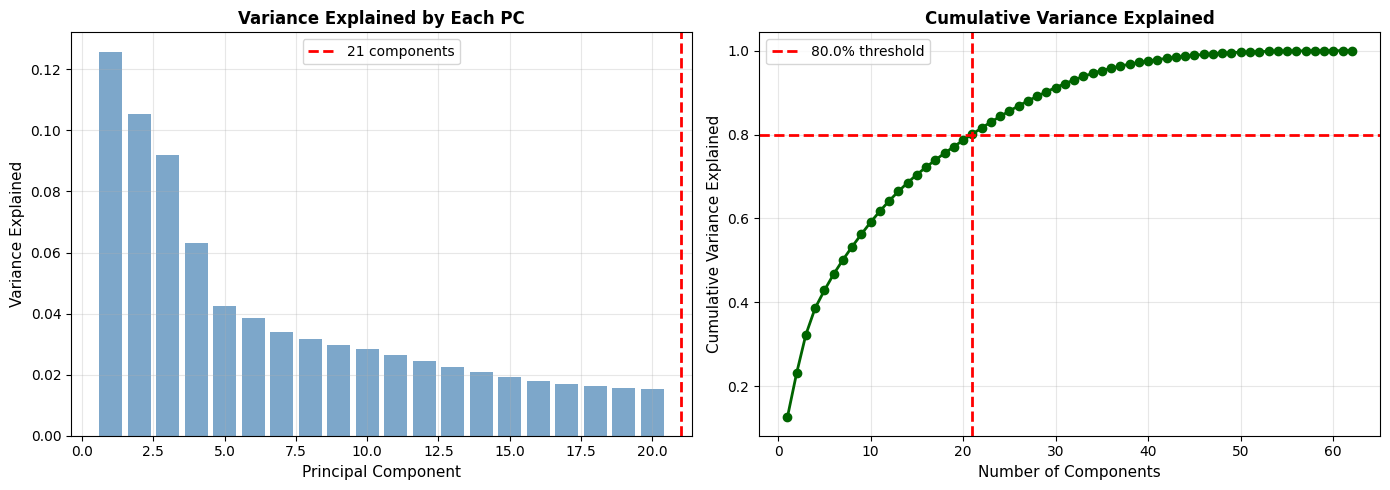


STEP 3: Select Original Factors from PCA Loadings

Loading threshold: 0.1270

Factors selected based on PCA loadings: 62

Top 15 factors by maximum absolute loading:
   1. rect_turn                     : 0.8640
   2. aftret_equity                 : 0.6274
   3. aftret_eq                     : 0.6274
   4. evm                           : 0.5405
   5. debt_ebitda                   : 0.5351
   6. pcf                           : 0.4781
   7. int_totdebt                   : 0.4774
   8. de_ratio                      : 0.4756
   9. dpr                           : 0.4537
  10. vol_6m                        : 0.4485
  11. lt_ppent                      : 0.4426
  12. vol_mom                       : 0.4371
  13. RVOL_3                        : 0.4365
  14. vol_ROC                       : 0.4313
  15. vol_3m                        : 0.4256


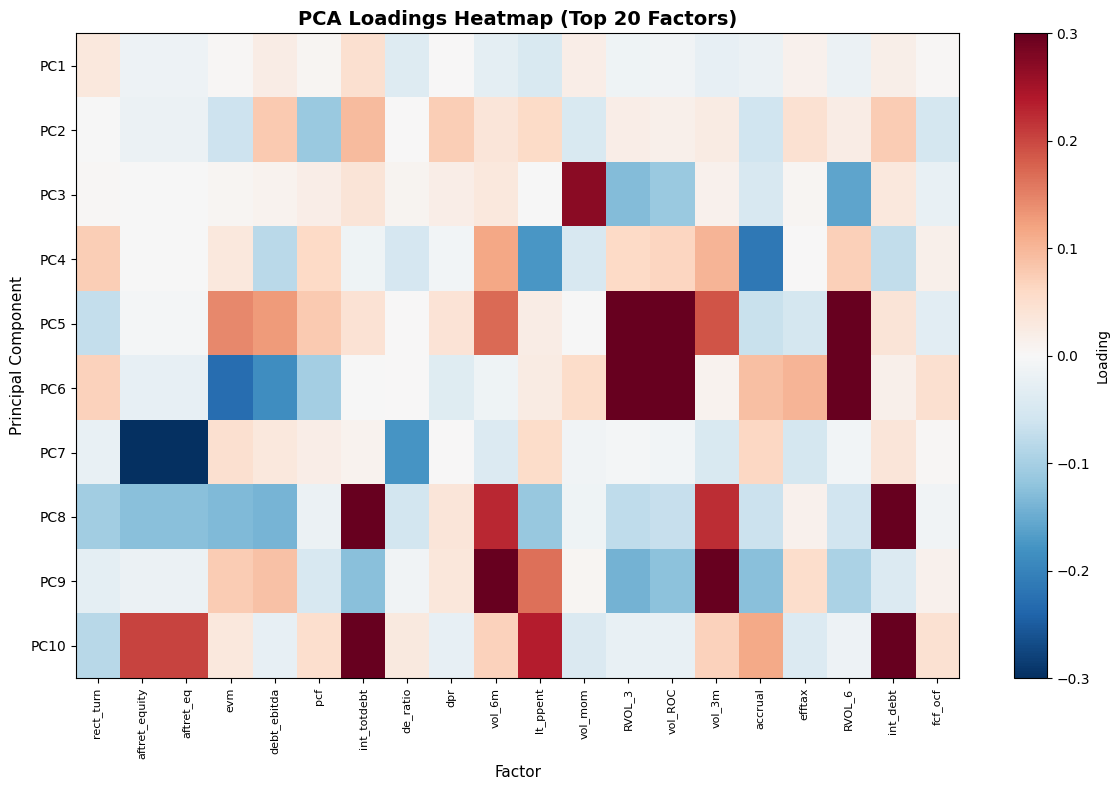


STEP 4: Fama-MacBeth Regression (Statistical Validation)
Number of time periods: 47

Statistically significant factors (|t| > 1.96): 10 out of 62

Top 15 factors by |t-statistic|:
   1. vol_mom                       : t =  23.416  ✓
   2. EMA_6                         : t = -10.880  ✓
   3. EMA_3                         : t =   8.289  ✓
   4. SMA_3                         : t =  -5.452  ✓
   5. bm                            : t =  -5.117  ✓
   6. vol_ROC                       : t =   2.413  ✓
   7. dltt_be                       : t =  -2.347  ✓
   8. ps                            : t =   2.336  ✓
   9. divyield                      : t =  -2.321  ✓
  10. lt_ppent                      : t =   2.193  ✓
  11. RVOL_6                        : t =   1.821  
  12. RVOL_3                        : t =  -1.792  
  13. sale_equity                   : t =  -1.638  
  14. roce                          : t =  -1.499  
  15. pay_turn                      : t =  -1.471  


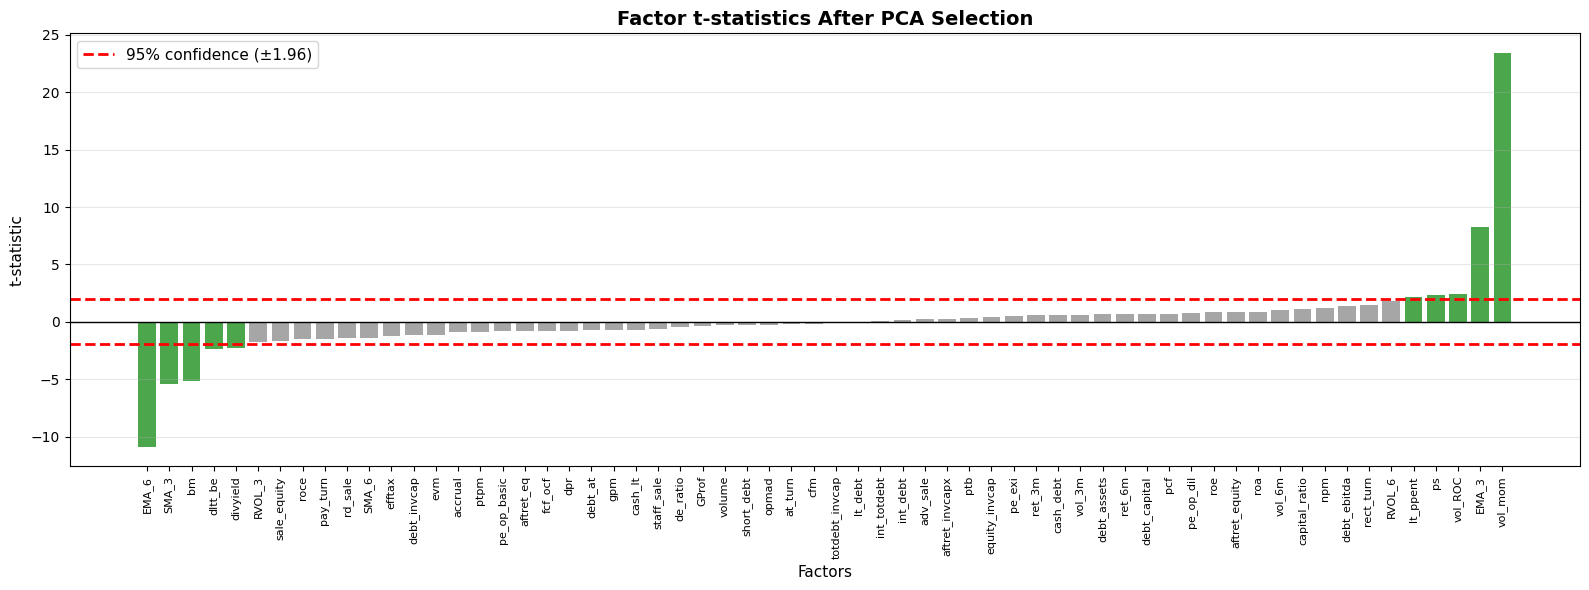


STEP 5: Compute Final Factor Premia
Final factors used: 10

Final Factor Premia (γ̄):
------------------------------------------------------------
  EMA_3                         : 0.084196  LONG ↑
  vol_mom                       : 0.046098  LONG ↑
  EMA_6                         : -0.028244  SHORT ↓
  SMA_3                         : -0.022601  SHORT ↓
  vol_ROC                       : 0.002147  LONG ↑
  bm                            : -0.000813  SHORT ↓
  ps                            : 0.000594  LONG ↑
  divyield                      : -0.000469  SHORT ↓
  lt_ppent                      : 0.000236  LONG ↑
  dltt_be                       : -0.000168  SHORT ↓

STEP 6: Portfolio Construction (Val + Test)
Out-of-sample data shape: (10959, 66)
Date range: 2022-12-31 00:00:00 to 2024-12-31 00:00:00
Total months: 25

Portfolio constructed for 24 months

PORTFOLIO PERFORMANCE SUMMARY

Number of periods: 24

📊 Mean Monthly Returns:
  Long leg:         0.851%
  Short leg:        0.876%
  L/S P

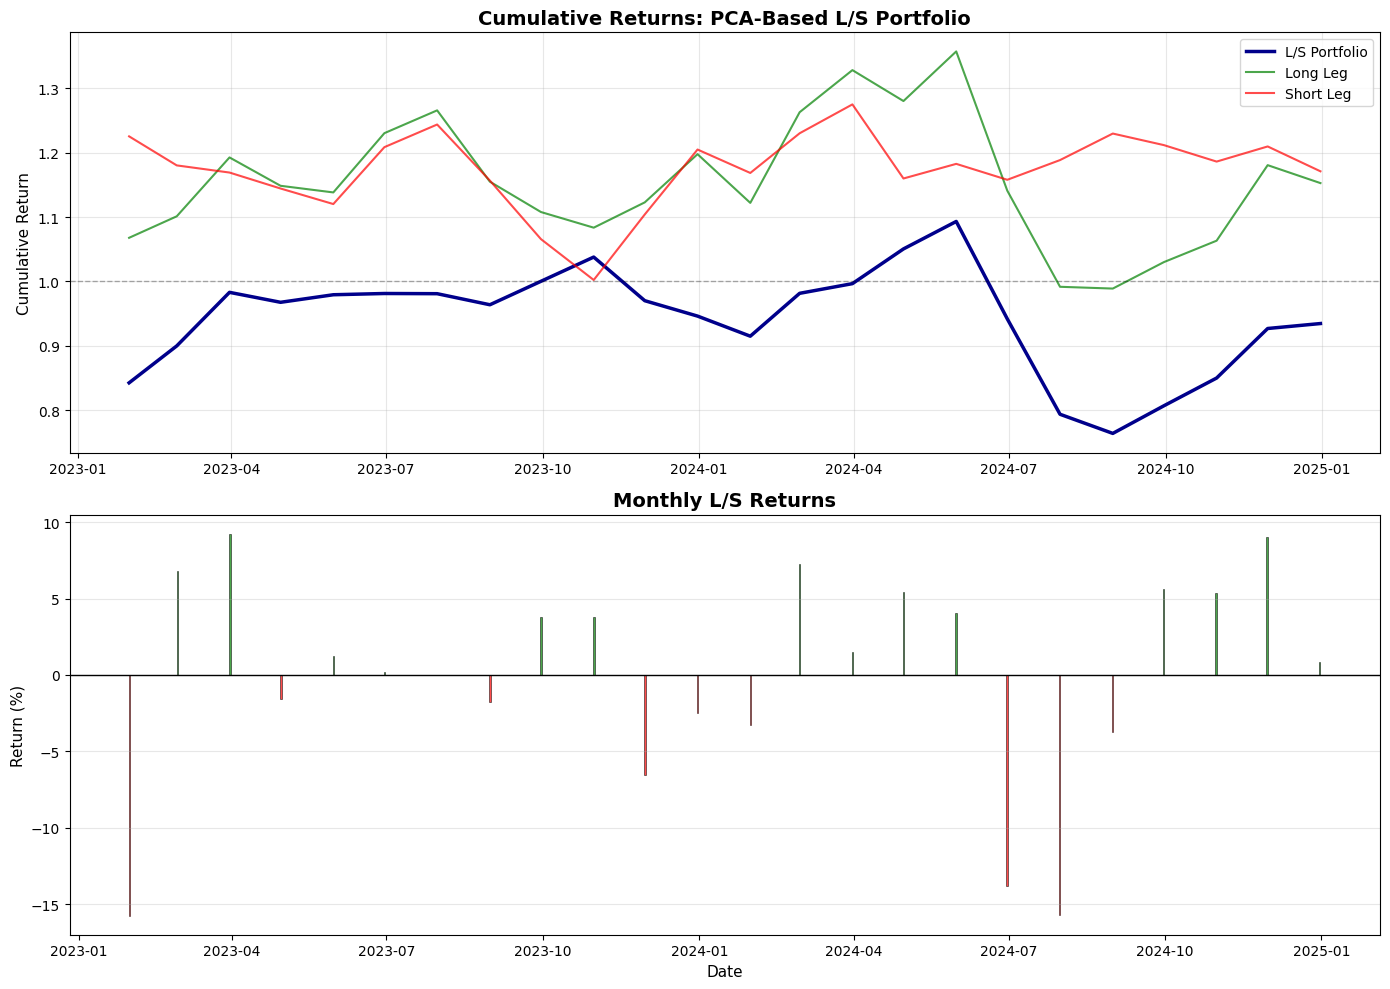

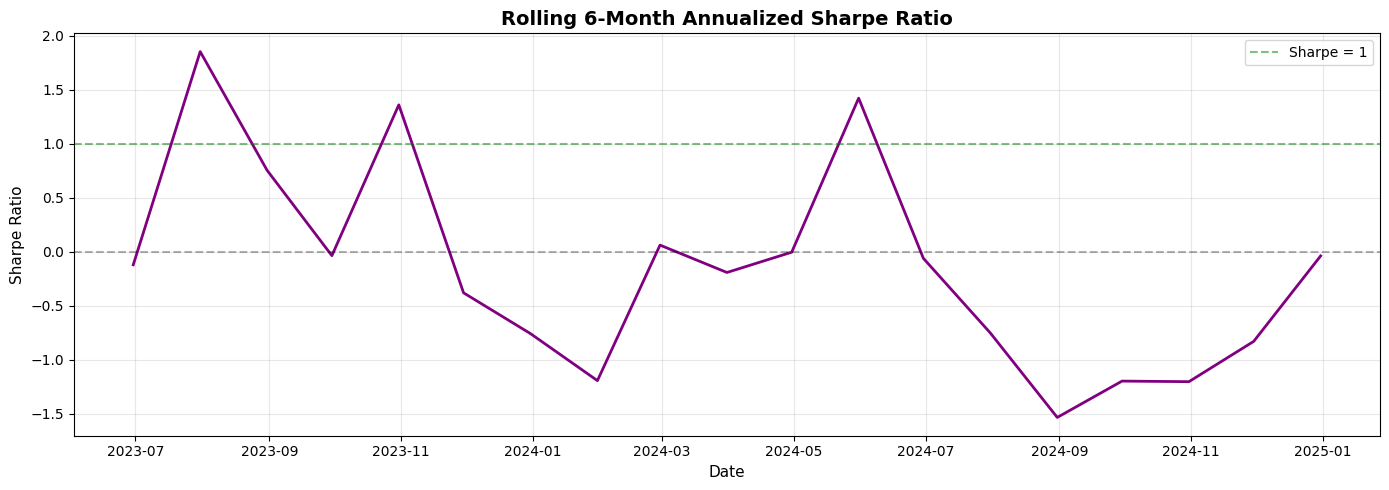


✅ PCA-Based Portfolio Analysis Complete!


In [4]:
# ========================================
# PCA-BASED LONG/SHORT PORTFOLIO STRATEGY
# ========================================

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import matplotlib.pyplot as plt

# ========================================
# DATA PREPARATION
# ========================================

df = wrds_file.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'ticker'])

# Drop price column if exists
if 'price' in df.columns:
    df = df.drop(columns=['price'])

# Identify factor columns
factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

print(f"Total factors: {len(factor_cols)}")
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Split data
train = df[(df['date'] >= "2019-01-01") & (df['date'] <= "2022-12-31")].copy()
val   = df[(df['date'] >= "2022-12-31") & (df['date'] <= "2023-12-31")].copy()
test  = df[(df['date'] >= "2023-12-31") & (df['date'] <= "2024-12-31")].copy()

print(f"\nTrain: {train.shape}")
print(f"Val: {val.shape}")
print(f"Test: {test.shape}")

# ========================================
# STEP 1: PREPARE DATA FOR PCA
# ========================================

print("\n" + "="*60)
print("STEP 1: Prepare Data for PCA")
print("="*60)

# Create standardized factor matrix from training data
train_factors_list = []

for dt, grp in train.groupby('date'):
    grp_clean = grp.dropna(subset=factor_cols)
    
    if len(grp_clean) < 10:
        continue
    
    # Cross-sectional standardization
    X_raw = grp_clean[factor_cols].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    # Check for NaN/inf
    if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
        continue
    
    train_factors_list.append(X_normalized)

# Stack all time periods
X_train_pca = pd.concat(train_factors_list, ignore_index=True)

print(f"Training observations for PCA: {X_train_pca.shape[0]}")
print(f"Number of factors: {X_train_pca.shape[1]}")

# ========================================
# STEP 2: PERFORM PCA
# ========================================

print("\n" + "="*60)
print("STEP 2: Principal Component Analysis")
print("="*60)

# Fit PCA
pca = PCA()
pca.fit(X_train_pca)

# Variance explained
var_explained = pca.explained_variance_ratio_
cum_var_explained = np.cumsum(var_explained)

# Select number of components (80% variance threshold)
variance_threshold = 0.80
n_components = np.argmax(cum_var_explained >= variance_threshold) + 1

print(f"\nVariance threshold: {variance_threshold*100}%")
print(f"Number of components selected: {n_components}")
print(f"Cumulative variance explained: {cum_var_explained[n_components-1]*100:.2f}%")

# Show top components
print(f"\nTop 10 Principal Components:")
for i in range(min(10, len(var_explained))):
    print(f"  PC{i+1}: {var_explained[i]*100:6.2f}% (Cumulative: {cum_var_explained[i]*100:6.2f}%)")

# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, min(21, len(var_explained)+1)), var_explained[:20], alpha=0.7, color='steelblue')
axes[0].axvline(n_components, color='red', linestyle='--', linewidth=2, label=f'{n_components} components')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Variance Explained', fontsize=11)
axes[0].set_title('Variance Explained by Each PC', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cum_var_explained)+1), cum_var_explained, marker='o', linewidth=2, color='darkgreen')
axes[1].axhline(variance_threshold, color='red', linestyle='--', linewidth=2, label=f'{variance_threshold*100}% threshold')
axes[1].axvline(n_components, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=11)
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# STEP 3: SELECT ORIGINAL FACTORS BASED ON LOADINGS
# ========================================

print("\n" + "="*60)
print("STEP 3: Select Original Factors from PCA Loadings")
print("="*60)

# Get loadings (components)
loadings = pca.components_[:n_components, :]  # Shape: (n_components, n_factors)
loadings_df = pd.DataFrame(
    loadings.T,
    index=factor_cols,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# Set threshold for important loadings
loading_threshold = 1 / np.sqrt(len(factor_cols))
print(f"\nLoading threshold: {loading_threshold:.4f}")

# Find factors with high loadings on any of the selected PCs
selected_factors = set()
factor_importance = defaultdict(float)

for pc_col in loadings_df.columns:
    high_loading_factors = loadings_df[abs(loadings_df[pc_col]) > loading_threshold].index.tolist()
    selected_factors.update(high_loading_factors)
    
    # Track max absolute loading for each factor
    for factor in high_loading_factors:
        factor_importance[factor] = max(factor_importance[factor], abs(loadings_df.loc[factor, pc_col]))

selected_factors = list(selected_factors)
print(f"\nFactors selected based on PCA loadings: {len(selected_factors)}")

# Show top factors by importance
print("\nTop 15 factors by maximum absolute loading:")
sorted_factors = sorted(factor_importance.items(), key=lambda x: x[1], reverse=True)
for i, (factor, importance) in enumerate(sorted_factors[:15], 1):
    print(f"  {i:2d}. {factor:30s}: {importance:.4f}")

# Visualize loadings heatmap for top factors
top_n_show = min(20, len(selected_factors))
top_factors_to_show = [f[0] for f in sorted_factors[:top_n_show]]

plt.figure(figsize=(12, 8))
# Select subset of PCs to display
n_pcs_to_show = min(10, n_components)
pc_cols_to_show = [f'PC{i+1}' for i in range(n_pcs_to_show)]
loadings_subset = loadings_df.loc[top_factors_to_show, pc_cols_to_show]
plt.imshow(loadings_subset.T, cmap='RdBu_r', aspect='auto', vmin=-0.3, vmax=0.3)
plt.colorbar(label='Loading')
plt.yticks(range(n_pcs_to_show), pc_cols_to_show)
plt.xticks(range(len(top_factors_to_show)), top_factors_to_show, rotation=90, fontsize=8)
plt.title(f'PCA Loadings Heatmap (Top {top_n_show} Factors)', fontsize=14, fontweight='bold')
plt.ylabel('Principal Component', fontsize=11)
plt.xlabel('Factor', fontsize=11)
plt.tight_layout()
plt.show()

# ========================================
# STEP 4: FAMA-MACBETH REGRESSION WITH SELECTED FACTORS
# ========================================

print("\n" + "="*60)
print("STEP 4: Fama-MacBeth Regression (Statistical Validation)")
print("="*60)

gamma_time_series = defaultdict(list)
dates_used = []

for dt, grp in train.groupby('date'):
    grp_clean = grp.dropna(subset=['ret_1m'] + selected_factors)
    
    if grp_clean.shape[0] < len(selected_factors) + 10:
        continue
    
    # Cross-sectional standardization
    X_raw = grp_clean[selected_factors].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
        continue
    
    y = grp_clean['ret_1m'].values
    
    # Cross-sectional regression
    reg = LinearRegression().fit(X_normalized.values, y)
    
    for i, fc in enumerate(selected_factors):
        gamma_time_series[fc].append(reg.coef_[i])
    
    dates_used.append(dt)

T = len(dates_used)
print(f"Number of time periods: {T}")

# Compute t-statistics
gamma_bar = {}
gamma_std = {}
t_stats = {}

for fc in selected_factors:
    arr = np.array(gamma_time_series[fc])
    gamma_bar[fc] = arr.mean()
    gamma_std[fc] = arr.std(ddof=1)
    t_stats[fc] = gamma_bar[fc] / (gamma_std[fc] / np.sqrt(T))

# Select statistically significant factors
significant_factors = [fc for fc in selected_factors if abs(t_stats[fc]) > 1.96]

print(f"\nStatistically significant factors (|t| > 1.96): {len(significant_factors)} out of {len(selected_factors)}")

print("\nTop 15 factors by |t-statistic|:")
sorted_tstats = sorted(t_stats.items(), key=lambda x: abs(x[1]), reverse=True)
for i, (fc, tstat) in enumerate(sorted_tstats[:15], 1):
    sig_mark = "✓" if fc in significant_factors else ""
    print(f"  {i:2d}. {fc:30s}: t = {tstat:7.3f}  {sig_mark}")

# Plot t-statistics
sorted_items = sorted(t_stats.items(), key=lambda x: x[1])
factors_sorted = [item[0] for item in sorted_items]
values_sorted = [item[1] for item in sorted_items]

plt.figure(figsize=(16, 6))
colors = ['green' if abs(v) > 1.96 else 'gray' for v in values_sorted]
plt.bar(factors_sorted, values_sorted, color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
plt.title("Factor t-statistics After PCA Selection", fontsize=14, fontweight='bold')
plt.ylabel("t-statistic", fontsize=11)
plt.xlabel("Factors", fontsize=11)
plt.xticks(rotation=90, fontsize=8)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ========================================
# STEP 5: COMPUTE FINAL FACTOR PREMIA
# ========================================

print("\n" + "="*60)
print("STEP 5: Compute Final Factor Premia")
print("="*60)

# Use significant factors only
final_factors = significant_factors if len(significant_factors) >= 3 else selected_factors[:10]
print(f"Final factors used: {len(final_factors)}")

gamma_final = defaultdict(list)

for dt, grp in train.groupby('date'):
    grp_clean = grp.dropna(subset=['ret_1m'] + final_factors)
    
    if grp_clean.shape[0] < len(final_factors) + 3:
        continue
    
    X_raw = grp_clean[final_factors].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
        continue
    
    y = grp_clean['ret_1m'].values
    reg = LinearRegression().fit(X_normalized.values, y)
    
    for i, fc in enumerate(final_factors):
        gamma_final[fc].append(reg.coef_[i])

# Average factor premia
gamma_bar_final = {fc: np.mean(gamma_final[fc]) for fc in final_factors}

print("\nFinal Factor Premia (γ̄):")
print("-" * 60)
for fc in sorted(gamma_bar_final.keys(), key=lambda x: abs(gamma_bar_final[x]), reverse=True):
    direction = "LONG ↑" if gamma_bar_final[fc] > 0 else "SHORT ↓"
    print(f"  {fc:30s}: {gamma_bar_final[fc]:8.6f}  {direction}")

# ========================================
# STEP 6: PORTFOLIO CONSTRUCTION
# ========================================

print("\n" + "="*60)
print("STEP 6: Portfolio Construction (Val + Test)")
print("="*60)

oos_data = pd.concat([val, test], ignore_index=True).copy()
oos_data = oos_data.sort_values(['ticker', 'date'])

print(f"Out-of-sample data shape: {oos_data.shape}")
print(f"Date range: {oos_data['date'].min()} to {oos_data['date'].max()}")

all_dates = sorted(oos_data['date'].unique())
print(f"Total months: {len(all_dates)}")

portfolio_returns = []

for i in range(len(all_dates) - 1):
    current_date = all_dates[i]
    next_date = all_dates[i + 1]
    
    grp_t = oos_data[oos_data['date'] == current_date].copy()
    grp_t1 = oos_data[oos_data['date'] == next_date].copy()
    
    if len(grp_t) < 20:
        continue
    
    # Normalize factors cross-sectionally at time t
    for fc in final_factors:
        if grp_t[fc].notna().sum() > 1:
            mean_val = grp_t[fc].mean()
            std_val = grp_t[fc].std()
            if std_val > 0:
                grp_t[fc] = (grp_t[fc] - mean_val) / std_val
            else:
                grp_t[fc] = 0
    
    # Predict returns
    grp_t['r_pred'] = 0.0
    for fc in final_factors:
        grp_t['r_pred'] += grp_t[fc].fillna(0) * gamma_bar_final[fc]
    
    # Use rolling market return expectation
    historical_market = oos_data[oos_data['date'] < current_date]['market_ret']
    if len(historical_market) >= 12:
        E_r_m = historical_market.tail(12).mean()
    else:
        E_r_m = 0.0
    
    grp_t['r_pred'] += E_r_m  # Add market component
    
    grp_t = grp_t.dropna(subset=['r_pred'])
    
    if len(grp_t) < 20:
        continue
    
    # Form portfolio
    grp_t = grp_t.sort_values('r_pred', ascending=False)
    
    long_tickers = grp_t.head(10)['ticker'].tolist()
    short_tickers = grp_t.tail(10)['ticker'].tolist()
    
    # Measure realized returns at t+1
    long_rets = grp_t1[grp_t1['ticker'].isin(long_tickers)]['ret_1m']
    short_rets = grp_t1[grp_t1['ticker'].isin(short_tickers)]['ret_1m']
    
    if len(long_rets) < 5 or len(short_rets) < 5:
        continue
    
    long_ret = long_rets.mean()
    short_ret = short_rets.mean()
    ls_ret = long_ret - short_ret
    
    portfolio_returns.append({
        'formation_date': current_date,
        'return_date': next_date,
        'long_return': long_ret,
        'short_return': short_ret,
        'ls_return': ls_ret,
        'n_stocks_t': len(grp_t),
        'n_long': len(long_rets),
        'n_short': len(short_rets)
    })

portfolio_df = pd.DataFrame(portfolio_returns)
print(f"\nPortfolio constructed for {len(portfolio_df)} months")

# ========================================
# STEP 7: PERFORMANCE EVALUATION
# ========================================

print("\n" + "="*60)
print("PORTFOLIO PERFORMANCE SUMMARY")
print("="*60)

if len(portfolio_df) == 0:
    print("\n⚠️  ERROR: No portfolio returns generated!")
else:
    # Risk-free rate
    r_f_annual = 0.04  # 4% annualized
    r_f_monthly = (1 + r_f_annual) ** (1/12) - 1
    
    print(f"\nNumber of periods: {len(portfolio_df)}")
    
    print(f"\n📊 Mean Monthly Returns:")
    print(f"  Long leg:       {portfolio_df['long_return'].mean()*100:7.3f}%")
    print(f"  Short leg:      {portfolio_df['short_return'].mean()*100:7.3f}%")
    print(f"  L/S Portfolio:  {portfolio_df['ls_return'].mean()*100:7.3f}%")
    
    print(f"\n📉 Volatility (Std Dev):")
    print(f"  Long leg:       {portfolio_df['long_return'].std()*100:7.3f}%")
    print(f"  Short leg:      {portfolio_df['short_return'].std()*100:7.3f}%")
    print(f"  L/S Portfolio:  {portfolio_df['ls_return'].std()*100:7.3f}%")
    
    # Sharpe Ratio with risk-free rate
    if portfolio_df['ls_return'].std() > 0:
        excess_return_monthly = portfolio_df['ls_return'].mean() - r_f_monthly
        sharpe_monthly = excess_return_monthly / portfolio_df['ls_return'].std()
        sharpe_annual = sharpe_monthly * np.sqrt(12)
        print(f"\n📈 Sharpe Ratio (r_f = {r_f_annual*100:.1f}%):")
        print(f"  Monthly:        {sharpe_monthly:7.3f}")
        print(f"  Annualized:     {sharpe_annual:7.3f}")
    
    # Cumulative returns
    portfolio_df['cum_long'] = (1 + portfolio_df['long_return']).cumprod()
    portfolio_df['cum_short'] = (1 + portfolio_df['short_return']).cumprod()
    portfolio_df['cum_ls'] = (1 + portfolio_df['ls_return']).cumprod()
    
    print(f"\n💰 Cumulative Returns:")
    print(f"  Long leg:       {(portfolio_df['cum_long'].iloc[-1] - 1)*100:7.2f}%")
    print(f"  Short leg:      {(portfolio_df['cum_short'].iloc[-1] - 1)*100:7.2f}%")
    print(f"  L/S Portfolio:  {(portfolio_df['cum_ls'].iloc[-1] - 1)*100:7.2f}%")
    
    # Win rate
    win_rate = (portfolio_df['ls_return'] > 0).sum() / len(portfolio_df)
    print(f"\n🎯 Win Rate: {win_rate*100:.1f}%")
    
    # Maximum drawdown
    cumulative = portfolio_df['cum_ls']
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    print(f"📉 Maximum Drawdown: {max_drawdown*100:.2f}%")

# ========================================
# STEP 8: VISUALIZATIONS
# ========================================

if len(portfolio_df) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Cumulative returns
    axes[0].plot(portfolio_df['return_date'], portfolio_df['cum_ls'], 
                 linewidth=2.5, label='L/S Portfolio', color='darkblue')
    axes[0].plot(portfolio_df['return_date'], portfolio_df['cum_long'], 
                 linewidth=1.5, label='Long Leg', alpha=0.7, color='green')
    axes[0].plot(portfolio_df['return_date'], portfolio_df['cum_short'], 
                 linewidth=1.5, label='Short Leg', alpha=0.7, color='red')
    axes[0].axhline(1, color='black', linestyle='--', alpha=0.3, linewidth=1)
    axes[0].set_title('Cumulative Returns: PCA-Based L/S Portfolio', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Cumulative Return', fontsize=11)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Monthly returns
    colors = ['green' if x > 0 else 'red' for x in portfolio_df['ls_return']]
    axes[1].bar(portfolio_df['return_date'], portfolio_df['ls_return']*100, 
                alpha=0.7, color=colors, edgecolor='black', linewidth=0.5)
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].set_title('Monthly L/S Returns', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=11)
    axes[1].set_ylabel('Return (%)', fontsize=11)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Rolling Sharpe
    window = 6
    if len(portfolio_df) >= window:
        portfolio_df['rolling_sharpe'] = (
            (portfolio_df['ls_return'].rolling(window).mean() - r_f_monthly) / 
            portfolio_df['ls_return'].rolling(window).std()
        ) * np.sqrt(12)
        
        plt.figure(figsize=(14, 5))
        plt.plot(portfolio_df['return_date'], portfolio_df['rolling_sharpe'], 
                 linewidth=2, color='purple')
        plt.axhline(0, color='black', linestyle='--', alpha=0.3)
        plt.axhline(1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
        plt.title(f'Rolling {window}-Month Annualized Sharpe Ratio', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=11)
        plt.ylabel('Sharpe Ratio', fontsize=11)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

print("\n✅ PCA-Based Portfolio Analysis Complete!")